In [9]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#ipython很好用，但是如果在ipython里已经import过的模块修改后需要重新reload就需要这样
#在执行用户代码前，重新装入软件的扩展和模块。
%load_ext autoreload   
#autoreload 2：装入所有 %aimport 不包含的模块。
%autoreload 2          

np.random.seed(1)      #指定随机种子

In [10]:
def zero_pad(X, pad):
    """
    """
    X_paded = np.pad(X, (
        (0, 0),           # 样本数，不填充
        (pad, pad),       # 高度上下各填充pad
        (pad, pad),       # 宽度。左右各填充pad
        (0, 0)),          # 通道数，不填充
        "constant", constant_values=0) # 以连续一样的值填充
    
    return X_paded

x.shape = (4, 3, 3, 2)
x_paded.shape = (4, 7, 7, 2)
x[1, 1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_paded[1, 1] = [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


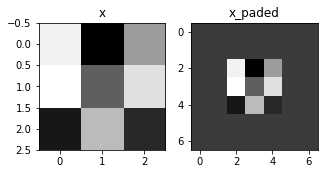

In [11]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_paded = zero_pad(x, 2)
#查看信息
print ("x.shape =", x.shape)
print ("x_paded.shape =", x_paded.shape)
print ("x[1, 1] =", x[1, 1])
print ("x_paded[1, 1] =", x_paded[1, 1])
# 绘图
fig, axarr = plt.subplots(1, 2)
axarr[0].set_title("x")
axarr[0].imshow(x[0, :, :, 0]) # 显示全部
axarr[1].set_title("x_paded")
axarr[1].imshow(x_paded[0, :, :, 0])

In [12]:
#
def conv_single_step(a_slice_prev, W, b):
    """
    """
    s = np.multiply(a_slice_prev, W) + b
    
    Z = np.sum(s)
    
    return Z

In [13]:
np.random.seed(1)

#切片大小和过滤器相同
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)

print("Z = " + str(Z))

Z = -23.1602122025


In [14]:
#向前传播
def conv_forward(A_prev, W, b, hparameteres):
    """"""
    # 获取上一层数据的信息
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # 获取权重的基本信息
    (f, f, n_C_prev, n_C) = W.shape
    
    #获取超参数hparameters的值
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # 计算卷积后的图像的宽度高度
    n_H = int((n_H_prev - f + 2 * pad)/ stride ) + 1
    n_W = int((n_W_prev - f + 2 * pad)/ stride ) + 1
    
    # 使用0来初始化卷积输出Z
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # 通过A_prev创建填充过了的A_preve_pad
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m): #遍历样本
        a_prev_pad = A_prev_pad[i] # 选择第i个样本扩充后的激活矩阵
        for h in range(n_H): # 竖直
            for w in range(n_W): # 水平
                for c in range(n_C): # 通道
                    # 定位当前切片位置？
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    # 取出
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    # 执行单步卷积
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:,:,:,c],b[0,0,0,c])
    
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    cache = (A_prev, W, b, hparameters)
    
    return (Z, cache)

In [15]:
np.random.seed(1)

A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)

hparameters = {"pad" : 2, "stride": 1}

Z , cache_conv = conv_forward(A_prev,W,b,hparameters)

print("np.mean(Z) = ", np.mean(Z))
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

np.mean(Z) =  0.155859324889
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


In [16]:
# 池化层
def pool_forward(A_prev, hparameters, mode="max"):
    """"""
        #获取输入数据的基本信息
    (m , n_H_prev , n_W_prev , n_C_prev) = A_prev.shape

    #获取超参数的信息
    f = hparameters["f"]
    stride = hparameters["stride"]

    #计算输出维度
    n_H = int((n_H_prev - f) / stride ) + 1
    n_W = int((n_W_prev - f) / stride ) + 1
    n_C = n_C_prev

    #初始化输出矩阵
    A = np.zeros((m , n_H , n_W , n_C))

    for i in range(m):                              #遍历样本
        for h in range(n_H):                        #在输出的垂直轴上循环
            for w in range(n_W):                    #在输出的水平轴上循环
                for c in range(n_C):                #循环遍历输出的通道
                    #定位当前的切片位置
                    vert_start = h * stride         #竖向，开始的位置
                    vert_end = vert_start + f       #竖向，结束的位置
                    horiz_start = w * stride        #横向，开始的位置
                    horiz_end = horiz_start + f     #横向，结束的位置
                    #定位完毕，开始切割
                    a_slice_prev = A_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]

                    #对切片进行池化操作
                    if mode == "max":
                        A[ i , h , w , c ] = np.max(a_slice_prev)
                    elif mode == "average":
                        A[ i , h , w , c ] = np.mean(a_slice_prev)

    #池化完毕，校验数据格式
    assert(A.shape == (m , n_H , n_W , n_C))

    #校验完毕，开始存储用于反向传播的值
    cache = (A_prev,hparameters)

    return A,cache

In [17]:
np.random.seed(1)
A_prev = np.random.randn(2,4,4,3)
hparameters = {"f":4 , "stride":1}

A , cache = pool_forward(A_prev,hparameters,mode="max")
A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print("----------------------------")
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

mode = max
A = [[[[ 1.74481176  1.6924546   2.10025514]]]


 [[[ 1.19891788  1.51981682  2.18557541]]]]
----------------------------
mode = average
A = [[[[-0.09498456  0.11180064 -0.14263511]]]


 [[[-0.09525108  0.28325018  0.33035185]]]]


In [26]:
# 卷积神经网络的反向传播
def conv_backward(dZ, cache):
    """"""
    #获取cache的值
    (A_prev, W, b, hparameters) = cache

    #获取A_prev的基本信息
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    #获取dZ的基本信息
    (m,n_H,n_W,n_C) = dZ.shape

    #获取权值的基本信息
    (f, f, n_C_prev, n_C) = W.shape

    #获取hparaeters的值
    pad = hparameters["pad"]
    stride = hparameters["stride"]

    #初始化各个梯度的结构????????
    dA_prev = np.zeros((m,n_H_prev,n_W_prev,n_C_prev))
    dW = np.zeros((f,f,n_C_prev,n_C))
    db = np.zeros((1,1,1,n_C))

    #前向传播中我们使用了pad，反向传播也需要使用，这是为了保证数据结构一致
    A_prev_pad = zero_pad(A_prev,pad)
    dA_prev_pad = zero_pad(dA_prev,pad)

    #现在处理数据
    for i in range(m):
        #选择第i个扩充了的数据的样本,降了一维??????????????
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]

        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    #定位切片位置
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f

                    #定位完毕，开始切片
                    a_slice = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]

                    #切片完毕，使用上面的公式计算梯度
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end,:] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i,h,w,c]
                    db[:,:,:,c] += dZ[i,h,w,c]
        #设置第i个样本最终的dA_prev,即把非填充的数据取出来。
        dA_prev[i,:,:,:] = da_prev_pad[pad:-pad, pad:-pad, :]

    #数据处理完毕，验证数据格式是否正确
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))

    return (dA_prev,dW,db)

In [27]:
np.random.seed(1)
#初始化参数
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2, "stride": 1}

#前向传播
Z , cache_conv = conv_forward(A_prev,W,b,hparameters)
#反向传播
dA , dW , db = conv_backward(Z,cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 9.60899067587
dW_mean = 10.5817412755
db_mean = 76.3710691956


In [33]:
# 池化层反向传播
# 最大池
def create_mask_from_window(x):
    """"""
    mask = x == np.max(x)
    
    return mask

In [34]:
np.random.seed(1)

x = np.random.randn(2,3)

mask = create_mask_from_window(x)

print("x = " + str(x)) 
print("mask = " + str(mask))

x = [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask = [[ True False False]
 [False False False]]


In [35]:
# 均值池化层
def distribute_value(dZ, shape):
    """"""
    # 获取矩阵大小
    (n_H, n_W) = shape
    
    # 计算平均值
    average = dz / (n_H * n_W)
    
    # 填充入矩阵
    a = np.ones(shape) * average
    
    return a

In [36]:
dz = 2
shape = (2,2)

a = distribute_value(dz,shape)
print("a = " + str(a))

a = [[ 0.5  0.5]
 [ 0.5  0.5]]


In [37]:
# 池化层的反向传播
def pool_backward(dA, cache, mode = "max"):
    """"""
    # 获取 cache中的值
    (A_prev , hparaeters) = cache

    #获取hparaeters的值
    f = hparaeters["f"]
    stride = hparaeters["stride"]

    #获取A_prev和dA的基本信息
    (m , n_H_prev , n_W_prev , n_C_prev) = A_prev.shape
    (m , n_H , n_W , n_C) = dA.shape

    #初始化输出的结构
    dA_prev = np.zeros_like(A_prev)

    #开始处理数据
    for i in range(m):
        a_prev = A_prev[i]      
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    #定位切片位置
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f

                    #选择反向传播的计算方式
                    if mode == "max":
                        #开始切片
                        a_prev_slice = a_prev[vert_start:vert_end,horiz_start:horiz_end,c]
                        #创建掩码
                        mask = create_mask_from_window(a_prev_slice)
                        #计算dA_prev
                        dA_prev[i,vert_start:vert_end,horiz_start:horiz_end,c] += np.multiply(mask,dA[i,h,w,c])

                    elif mode == "average":
                        #获取dA的值
                        da = dA[i,h,w,c]
                        #定义过滤器大小
                        shape = (f,f)
                        #平均分配
                        dA_prev[i,vert_start:vert_end, horiz_start:horiz_end ,c] += distribute_value(da,shape)
    #数据处理完毕，开始验证格式
    assert(dA_prev.shape == A_prev.shape)

    return dA_prev

In [38]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

mode = max
mean of dA =  0.145713902729
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.145713902729
dA_prev[1,1] =  [[ 1.  1.]
 [ 2.  2.]
 [ 1.  1.]]


In [59]:
# 神经网络应用
import math
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.python.framework import ops

import cnn_utils
np.random.seed(1)

y = 2


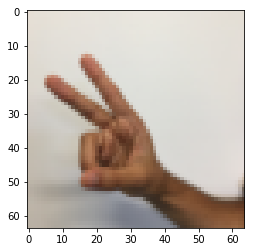

In [60]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = cnn_utils.load_dataset()
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [61]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = cnn_utils.convert_to_one_hot(Y_train_orig, 6).T
Y_test = cnn_utils.convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [62]:
# 创建占位符  ?????????????
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    为session创建占位符

    参数：
        n_H0 - 实数，输入图像的高度
        n_W0 - 实数，输入图像的宽度
        n_C0 - 实数，输入的通道数
        n_y  - 实数，分类数

    输出：
        X - 输入数据的占位符，维度为[None, n_H0, n_W0, n_C0]，类型为"float"
        Y - 输入数据的标签的占位符，维度为[None, n_y]，维度为"float"
    """
    X = tf.placeholder(tf.float32,[None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32,[None, n_y])

    return X,Y

In [63]:
X , Y = create_placeholders(64,64,3,6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder_2:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_3:0", shape=(?, 6), dtype=float32)


In [64]:
# 初始化参数
def initialize_parameters():
    """
    初始化权值矩阵，这里我们把权值矩阵硬编码：
    W1 : [4, 4, 3, 8]
    W2 : [2, 2, 8, 16]

    返回：
        包含了tensor类型的W1、W2的字典
    """
    tf.set_random_seed(1)

    W1 = tf.get_variable("W1",[4,4,3,8],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2",[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))

    parameters = {"W1": W1,
                  "W2": W2}

    return parameters

In [65]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

    sess_test.close()

W1 = [ 0.00131723  0.14176141 -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


In [66]:
# 向前传播
def forward_propagation(X,parameters):
    """
    实现前向传播
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    参数：
        X - 输入数据的placeholder，维度为(输入节点数量，样本数量)
        parameters - 包含了“W1”和“W2”的python字典。

    返回：
        Z3 - 最后一个LINEAR节点的输出

    """
    W1 = parameters['W1']
    W2 = parameters['W2']

    #Conv2d : 步伐：1，填充方式：“SAME”
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding="SAME")
    #ReLU ：
    A1 = tf.nn.relu(Z1)
    #Max pool : 窗口大小：8x8，步伐：8x8，填充方式：“SAME”
    P1 = tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding="SAME")

    #Conv2d : 步伐：1，填充方式：“SAME”
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding="SAME")
    #ReLU ：
    A2 = tf.nn.relu(Z2)
    #Max pool : 过滤器大小：4x4，步伐：4x4，填充方式：“SAME”
    P2 = tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=[1,4,4,1],padding="SAME")

    #一维化上一层的输出
    P = tf.contrib.layers.flatten(P2)

    #全连接层（FC）：使用没有非线性激活函数的全连接层
    Z3 = tf.contrib.layers.fully_connected(P,6,activation_fn=None)

    return Z3

In [67]:
tf.reset_default_graph()
np.random.seed(1)

with tf.Session() as sess_test:
    X,Y = create_placeholders(64,64,3,6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)

    init = tf.global_variables_initializer()
    sess_test.run(init)

    a = sess_test.run(Z3,{X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " + str(a))

    sess_test.close()

Z3 = [[ 1.44169843 -0.24909666  5.45049906 -0.26189619 -0.20669907  1.36546707]
 [ 1.40708458 -0.02573211  5.08928013 -0.48669922 -0.40940708  1.26248586]]


In [68]:
# 计算成本
def compute_cost(Z3,Y):
    """
    计算成本
    参数：
        Z3 - 正向传播最后一个LINEAR节点的输出，维度为（6，样本数）。
        Y - 标签向量的placeholder，和Z3的维度相同

    返回：
        cost - 计算后的成本

    """

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))

    return cost

In [69]:
tf.reset_default_graph()

with tf.Session() as sess_test:
    np.random.seed(1)
    X,Y = create_placeholders(64,64,3,6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)

    init = tf.global_variables_initializer()
    sess_test.run(init)
    a = sess_test.run(cost,{X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

    sess_test.close()

cost = 4.66487


In [70]:
# 构建模型
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009, 
         num_epochs=100,minibatch_size=64,print_cost=True,isPlot=True):
    """
    使用TensorFlow实现三层的卷积神经网络
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    参数：
        X_train - 训练数据，维度为(None, 64, 64, 3)
        Y_train - 训练数据对应的标签，维度为(None, n_y = 6)
        X_test - 测试数据，维度为(None, 64, 64, 3)
        Y_test - 训练数据对应的标签，维度为(None, n_y = 6)
        learning_rate - 学习率
        num_epochs - 遍历整个数据集的次数
        minibatch_size - 每个小批量数据块的大小
        print_cost - 是否打印成本值，每遍历100次整个数据集打印一次
        isPlot - 是否绘制图谱

    返回：
        train_accuracy - 实数，训练集的准确度
        test_accuracy - 实数，测试集的准确度
        parameters - 学习后的参数
    """
    ops.reset_default_graph()  #能够重新运行模型而不覆盖tf变量
    tf.set_random_seed(1)    #确保你的数据和我一样
    seed = 3                 #指定numpy的随机种子
    (m , n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []

    #为当前维度创建占位符
    X , Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    #初始化参数
    parameters = initialize_parameters()

    #前向传播
    Z3 = forward_propagation(X,parameters)

    #计算成本
    cost = compute_cost(Z3,Y)

    #反向传播，由于框架已经实现了反向传播，我们只需要选择一个优化器就行了
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    #全局初始化所有变量
    init = tf.global_variables_initializer()

    #开始运行
    with tf.Session() as sess:
        #初始化参数
        sess.run(init)
        #开始遍历数据集
        for epoch in range(num_epochs):
            minibatch_cost = 0
            num_minibatches = int(m / minibatch_size) #获取数据块的数量
            seed = seed + 1
            minibatches = cnn_utils.random_mini_batches(X_train,Y_train,minibatch_size,seed) 

            #对每个数据块进行处理
            for minibatch in minibatches:
                #选择一个数据块
                (minibatch_X,minibatch_Y) = minibatch
                #最小化这个数据块的成本
                _ , temp_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X, Y:minibatch_Y})

                #累加数据块的成本值
                minibatch_cost += temp_cost / num_minibatches

            #是否打印成本
            if print_cost:
                #每5代打印一次
                if epoch % 5 == 0:
                    print("当前是第 " + str(epoch) + " 代，成本值为：" + str(minibatch_cost))

            #记录成本
            if epoch % 1 == 0:
                costs.append(minibatch_cost)

        #数据处理完毕，绘制成本曲线
        if isPlot:
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()

        #开始预测数据
        ## 计算当前的预测情况
        predict_op = tf.arg_max(Z3,1)
        corrent_prediction = tf.equal(predict_op , tf.arg_max(Y,1))

        ##计算准确度
        accuracy = tf.reduce_mean(tf.cast(corrent_prediction,"float"))
        print("corrent_prediction accuracy= " + str(accuracy))

        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuary = accuracy.eval({X: X_test, Y: Y_test})

        print("训练集准确度：" + str(train_accuracy))
        print("测试集准确度：" + str(test_accuary))

        return (train_accuracy,test_accuary,parameters)

当前是第 0 代，成本值为：1.92133239657
当前是第 5 代，成本值为：1.90415570885
当前是第 10 代，成本值为：1.90430886298
当前是第 15 代，成本值为：1.90447724611
当前是第 20 代，成本值为：1.90187560767
当前是第 25 代，成本值为：1.7840776518
当前是第 30 代，成本值为：1.68105053157
当前是第 35 代，成本值为：1.61820664257
当前是第 40 代，成本值为：1.59797097743
当前是第 45 代，成本值为：1.56670662761
当前是第 50 代，成本值为：1.55448678136
当前是第 55 代，成本值为：1.50218752027
当前是第 60 代，成本值为：1.46103582531
当前是第 65 代，成本值为：1.30447863787
当前是第 70 代，成本值为：1.20150190592
当前是第 75 代，成本值为：1.14423296973
当前是第 80 代，成本值为：1.09678546339
当前是第 85 代，成本值为：1.08199167997
当前是第 90 代，成本值为：1.05407666042
当前是第 95 代，成本值为：1.02599899843
当前是第 100 代，成本值为：1.0072266385
当前是第 105 代，成本值为：0.958921402693
当前是第 110 代，成本值为：0.952206138521
当前是第 115 代，成本值为：0.96485876292
当前是第 120 代，成本值为：0.92410344258
当前是第 125 代，成本值为：0.887085091323
当前是第 130 代，成本值为：0.896753869951
当前是第 135 代，成本值为：0.856982089579
当前是第 140 代，成本值为：0.852897379547
当前是第 145 代，成本值为：0.831404868513


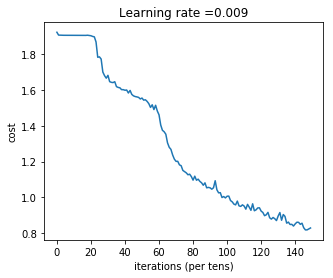

corrent_prediction accuracy= Tensor("Mean_1:0", shape=(), dtype=float32)
训练集准确度：0.714815
测试集准确度：0.683333


In [71]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test,num_epochs=150)